# Проект: вариант 2
## Задание 1. A/B–тестирование

### Входные данные

В качестве входных данных вы имеете 4 csv-файла:

```groups.csv``` – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)

```groups_add.csv``` – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

```active_studs.csv``` – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.

```checks.csv``` – файл с информацией об оплатах пользователей в дни проведения эксперимента.


## Импорт библиотек и загрузка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
groups = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/UhyYx41rTt3clQ", sep=';')
groups_add = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/5Kxrz02m3IBUwQ")
active_studs = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ")
checks = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/pH1q-VqcxXjsVA", sep=';')

### Предварительно посмотрим на данные

Оценим размеры датасетов, какие типы данных по колонкам, есть ли пропуски

In [ ]:
for i in [groups, groups_add, active_studs, checks]:
    print(i.shape)
    print('')
    print(i.info())
    print('')
    print(i.isnull().sum().sum())
    print('')

(74484, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None

0

(92, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
None

0

(8341, 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
None

0

(541, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540

In [ ]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [ ]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [ ]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [ ]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


Так как файл groups_add - является дополнительным к groups, то их можно сразу объединить и далее работать с общим файлом

In [ ]:
group = pd.concat([groups, groups_add])
group.shape

(74576, 2)

In [ ]:
# Сделаем джоин по двум датасетам для отбора только тех пользователей, которые заходили на платформу в дни проведения эксперимента.
active_checks = pd.merge(checks, active_studs, on='student_id', how='inner')
active_checks.shape

(392, 2)

Аналогично сделаем с объединенным файлом group и active_studs, чтобы потом можно было объединить всё в один датасет

In [ ]:
#Делаем правый джоин, чтобы не потерять активных пользователей
#student_id можно дропнуть, чтобы не дублировать колонки
active_group = pd.merge(group, active_studs, left_on='id', right_on='student_id', how='right').drop(columns=['student_id'])
active_group.shape

(8341, 2)

In [ ]:
active_group.head()

,id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B


In [ ]:
# Объединим всё вместе
df_final = pd.merge(active_group, active_checks, left_on='id', right_on='student_id', how='left').drop(columns=['student_id'])
print(df_final.isna().sum())
print('')

id        0
grp       0
rev    7949
dtype: int64



Заметим, что в поле rev много пропущенных значений. Объясняется это тем, что данные пользователи просто не совершили покупок в дни эксперимента. Логично будет их вычеркнуть из нашего подготовленного датасета

In [ ]:
df = df_final.query('rev.isna() == False')
df.head()

,id,grp,rev
62,1184303,A,1530.0000
67,3354191,B,1900.0001
77,3278734,B,1900.0000
99,720651,A,1980.0000
193,1232221,B,1900.0000


### Расчеты метрик и проверка статистических гипотез

В ходе анализа были расмотрены следующие метрики: CR, ARPU, ARPPU, Средний чек.
Выбор этих четырёх метрик позволяет:
- Оценить эффективность новой механики с точки зрения вовлечённости (CR),
- Понять её бизнес-ценность (ARPU, ARPPU),
- Проверить, не ухудшилось ли качество платежей (средний чек).
- Все метрики дополняют друг друга и дают целостную картину поведения пользователей в эксперименте.

In [ ]:
# Кол-во активных пользователей в каждой группе
active_users = df_final.groupby('grp')['id'].nunique()

# Кол-во платящих
paying_users = df.groupby('grp')['id'].nunique()

# Конверсия
conversion = paying_users / active_users

# ARPU (на всех активных)
arpu = df.groupby('grp')['rev'].sum() / active_users

# ARPPU (на платящих)
arppu = df.groupby('grp')['rev'].sum() / paying_users

# Средний чек (по всем платежам)
mean_check = df.groupby('grp')['rev'].mean()

In [ ]:
active_users

grp
A    1538
B    6803
Name: id, dtype: int64

In [ ]:
paying_users

grp
A     78
B    314
Name: id, dtype: int64

In [ ]:
conversion

grp
A    0.050715
B    0.046156
Name: id, dtype: float64

In [ ]:
arpu

grp
A    47.347204
B    58.058798
dtype: float64

In [ ]:
arppu

grp
A     933.589744
B    1257.878992
dtype: float64

In [ ]:
mean_check

grp
A     933.589744
B    1257.878992
Name: rev, dtype: float64

### Выводы по метрикам
- Конверсия упала
  
В группе B меньше людей платят по сравнению с контрольной. Это негативный сигнал с точки зрения вовлечённости.

- Доход на пользователя (ARPU) вырос

Несмотря на меньшую конверсию, доход с одного активного пользователя вырос — вероятно, из-за роста суммы одной покупки.

- Чек выше
  
Те, кто платит, тратят существенно больше — +35% в группе B.

Далее проведем статистические тесты, чтобы понять:

Является ли разница по CR статистически значимой? (z-тест для пропорций)

Является ли разница по ARPU и среднему чеку значимой? (t-test или бутстрап)

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

z_stat, pval_conv = proportions_ztest(
    count=[78, 314],
    nobs=[1538, 6803]
)
print(f'P-value по конверсии: {pval_conv:.4f}')

P-value по конверсии: 0.4455


In [ ]:
from scipy.stats import ttest_ind

rev_a = df[df['grp'] == 'A']['rev']
rev_b = df[df['grp'] == 'B']['rev']

t_stat, pval_check = ttest_ind(rev_a, rev_b, equal_var=False)
print(f'P-value по среднему чеку: {pval_check:.4f}')

P-value по среднему чеку: 0.0051


In [ ]:
rev_a_all = df_final[df_final['grp'] == 'A']['rev'].fillna(0).values
rev_b_all = df_final[df_final['grp'] == 'B']['rev'].fillna(0).values

def bootstrap_diff(data1, data2, n_boot=10000):
    np.random.seed(0)
    diffs = []
    for _ in range(n_boot):
        s1 = np.random.choice(data1, size=len(data1), replace=True)
        s2 = np.random.choice(data2, size=len(data2), replace=True)
        diffs.append(np.mean(s2) - np.mean(s1))
    return np.percentile(diffs, [2.5, 97.5])

ci_arpu = bootstrap_diff(rev_a_all, rev_b_all)
print(f'95% доверительный интервал по ARPU: {ci_arpu}')

95% доверительный интервал по ARPU: [-6.03722936 26.50695932]


### Выводы

1. Конверсия в оплату упала, но статистически значимо не отличается → нельзя утверждать, что новая механика реально мешает платить.
2. Средний чек вырос значимо → пользователи, которые платят, платят больше.
3. ARPU не отличается значимо → совокупный доход с пользователя не гарантированно увеличивается.

На основе текущих данных:
- Основной плюс: значительное увеличение среднего чека;
- Основной минус: конверсия немного ниже, но не значимо;
- ARPU — как итоговая бизнес-метрика — не улучшилась значимо.

По итогам эксперимента результаты получились неоднозначные, поэтому рекомендуется:
- Запустить её в ограниченном сегменте — например, на 20–30% аудитории;
- Собрать больше данных, чтобы повысить статистическую мощность тестов;
- Или доработать механику, сохранив высокие чеки, но повысив CR.



## Задание 3. Python
### 3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [ ]:
def recalculate_metrics(groups, groups_add_path, active_studs, checks):
    # Загружаем groups_add с возможными другими названиями колонок
    groups_add_raw = pd.read_csv(groups_add_path)

    # Переименуем колонки, приведем к стандартному виду
    groups_add_raw.columns = ['id', 'grp']

    # Объединяем основную и дополнительную таблицу
    all_groups = pd.concat([groups, groups_add_raw], ignore_index=True)

    # Получаем только активных пользователей
    active_checks = pd.merge(checks, active_studs, on='student_id', how='inner')
    active_group = pd.merge(all_groups, active_studs, left_on='id', right_on='student_id', how='right').drop(columns='student_id')

    df_final = pd.merge(active_group, active_checks, left_on='id', right_on='student_id', how='left').drop(columns='student_id')
    df_paid = df_final.query('rev.notna()')

    # Считаем метрики
    active_users = active_group.groupby('grp')['id'].count()
    paying_users = df_paid.groupby('grp')['id'].count()
    conversion = (paying_users / active_users).fillna(0)

    arpu = df_final.groupby('grp')['rev'].mean().fillna(0)
    arppu = df_paid.groupby('grp')['rev'].mean()
    mean_check = arppu.copy()  # если один чек на пользователя

    metrics = pd.DataFrame({
        'Active Users': active_users,
        'Paying Users': paying_users,
        'Conversion': conversion,
        'ARPU': arpu,
        'ARPPU': arppu,
        'Mean Check': mean_check
    })

    return metrics.reset_index()

In [ ]:
metrics = recalculate_metrics(groups, "https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/5Kxrz02m3IBUwQ", active_studs, checks)
metrics

,grp,Active Users,Paying Users,Conversion,ARPU,ARPPU,Mean Check
0,A,1538,78,0.050715,933.589744,933.589744,933.589744
1,B,6803,314,0.046156,1257.878992,1257.878992,1257.878992


In [ ]:
def plot_metrics(metrics_df):
    metrics = metrics_df.columns[1:]  # исключаем 'grp'
    groups = metrics_df['grp'].unique()

    for metric in metrics:
        plt.figure(figsize=(6, 4))
        sns.barplot(data=metrics_df, x='grp', y=metric, palette='Set2')

        plt.title(f'{metric} по группам')
        plt.xlabel('Группа')
        plt.ylabel(metric)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

C:\Users\Эдгар\AppData\Local\Temp\ipykernel_3512\3687053718.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='grp', y=metric, palette='Set2')


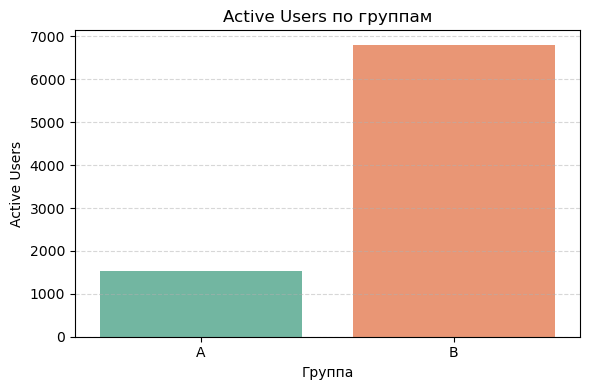

C:\Users\Эдгар\AppData\Local\Temp\ipykernel_3512\3687053718.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='grp', y=metric, palette='Set2')


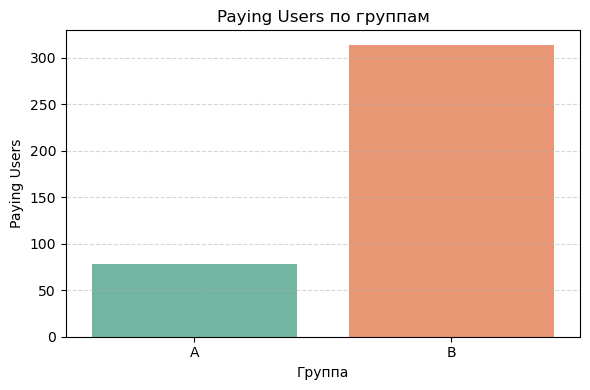

C:\Users\Эдгар\AppData\Local\Temp\ipykernel_3512\3687053718.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='grp', y=metric, palette='Set2')


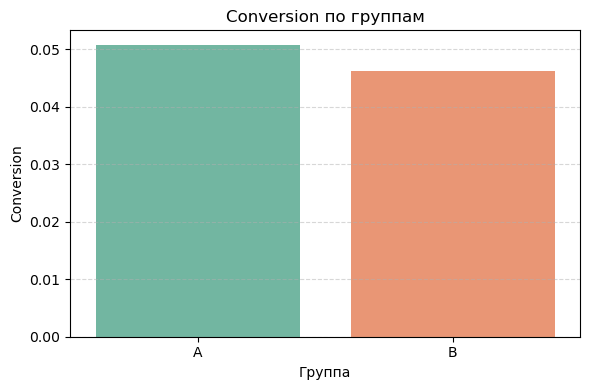

C:\Users\Эдгар\AppData\Local\Temp\ipykernel_3512\3687053718.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='grp', y=metric, palette='Set2')


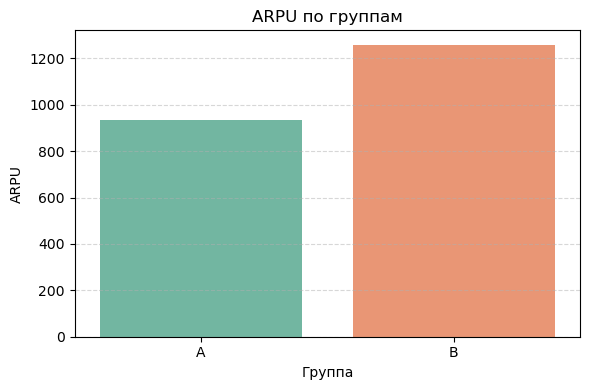

C:\Users\Эдгар\AppData\Local\Temp\ipykernel_3512\3687053718.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='grp', y=metric, palette='Set2')


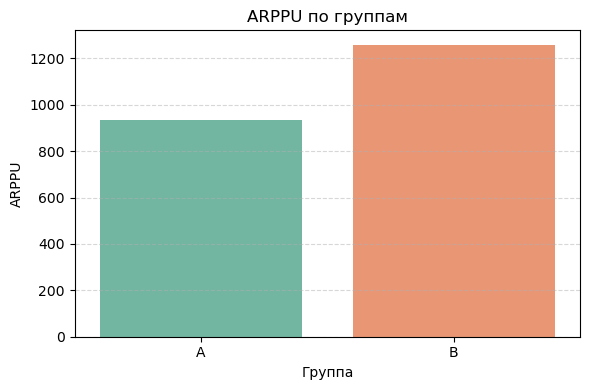

C:\Users\Эдгар\AppData\Local\Temp\ipykernel_3512\3687053718.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='grp', y=metric, palette='Set2')


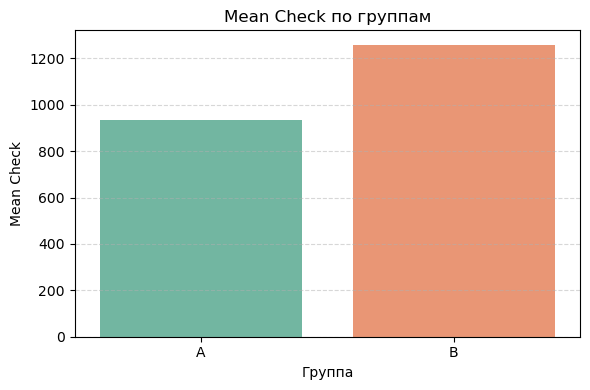

In [ ]:
plot_metrics(metrics)